In [1]:
from __future__ import division, print_function
import os

import pymongo as pm
import gridfs
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import signal

import jupyter_utils as utils

## Load from DB and metafile

In [2]:
def load_metafile(meta_path):
    with open(meta_path) as meta_file:
        vd_name_list = []
        for line in meta_file:
            vd_name = line.split(' ')[0]
            vd_name_list.append(vd_name)
    return vd_name_list

In [3]:
meta_path = '/data4/shetw/breakfast/metafiles/videos_test_split1_sample.meta'
vd_name_list = load_metafile(meta_path)

In [4]:
len(vd_name_list)

50

In [5]:
def load_from_mongoDB(conn, dbname, colname, gridfs_name, exp_id):
    r = conn[dbname][colname].find({'exp_id': exp_id, 'validation_results': {'$exists': True}})
    r = list(r)
    
    reload(utils)

    idval = r[-1]['_id']
    saved_data = utils.get_cached_or_load(
            idval, conn = conn, dbname = dbname,
            colname = colname, gridfs_name = gridfs_name, big_dict = {})

    data_dict = saved_data['validation_results']['pred_error']
    return data_dict['loss'], data_dict['index']

In [6]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError, msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [7]:
def get_boundaries(loss):
    predErrors = loss
    predErrors = movingaverage(predErrors, 80)
    predErrors = np.gradient(np.array(predErrors)).tolist()

    predBoundaries = signal.argrelextrema(np.array(predErrors), np.greater, order=int(0.57899*200))[0].tolist()
    predBoundaries.append(len(loss)-1)
    return predBoundaries

In [8]:
def split_video_losses(all_loss, all_index):
    """ Split the losses in DB into the loss of each video """
    losses = [[] for _ in range(all_index.max()+1)]
    for i, loss in enumerate(all_loss):
        losses[all_index[i]].append(loss)
    return losses

In [11]:
# Database path
conn = pm.MongoClient(port=27007)
dbname = "ppf"
colname = "breakfast_loss.files"
gridfs_name = "breakfast_loss"
exp_id = "ppf_test_sample_ramdom"

In [12]:
loss, index = load_from_mongoDB(conn, dbname, colname, gridfs_name, exp_id)

In [13]:
loss_list = split_video_losses(loss, index)
bdr_list = [get_boundaries(l) for l in loss_list]
print(len(loss_list))

50


## Visualization

In [14]:
# Plot function
def plot_error_segment_on_ax(errors, boundaries, gt_bdr, fps, ax, xlim, title=None):
    seconds = [i/fps for i in range(len(errors))]
    ax.plot(seconds, errors, linewidth=1)
    ax.set_xlim(left=0, right=xlim)
    for b in boundaries:
        ax.axvline(x=b/fps, ymin=0, ymax=0.3, c='y', linewidth=1)
    if gt_bdr is not None:
        for b in gt_bdr:
            ax.axvline(x=b/fps, ymin=0, ymax=0.3, c='r', linewidth=1)
    if title is not None:
        ax.set_title(title)

GT_ROOT = "/data4/shetw/breakfast/activity_groundtruth"    
def get_groundtruth_boundary(vd_name):
    name_splits = vd_name.split('_')
    if name_splits[-1] == 'ch0' or name_splits[-1] == 'ch1':
        gt_name = name_splits[0] + '_' + name_splits[-2] + '.txt'
    else:
        gt_name = name_splits[0] + '_' + name_splits[-1] + '.txt'
    gt_path = os.path.join(GT_ROOT, gt_name)
    # Groundtruth frame labels
    gt_bdr = []
    with open(gt_path, 'rb') as gt_file:
        for line in gt_file:
            data, className = line[:-3].split(' ')
            _, toFrame = [int(x) for x in data.split('-')]
            gt_bdr.append(toFrame-1)
    return gt_bdr

def plot_multi_errors(vd_name_list, fps, loss_list, bdr_list, xlim, plot_gt=True, xlabel="Second"):
    N = len(loss_list)
    NCOLS = 1
    NROWS = int(math.ceil(N/NCOLS))
    fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(15, NROWS/NCOLS*3))
    
    for i, error in enumerate(loss_list):
        ax = axes[i]
        video_fname = vd_name_list[i]
        title = video_fname
        pred_bdr = bdr_list[i][:-1]
        if plot_gt:
            gt_bdr = get_groundtruth_boundary(video_fname)[:-1]
        else:
            gt_bdr = None
        plot_error_segment_on_ax(error, pred_bdr, gt_bdr, fps, ax, xlim, title)
    fig.text(0.5, -0.01, xlabel, ha='center')
    fig.text(-0.01, 0.5, 'Prediction error', va='center', rotation='vertical')
    plt.tight_layout()

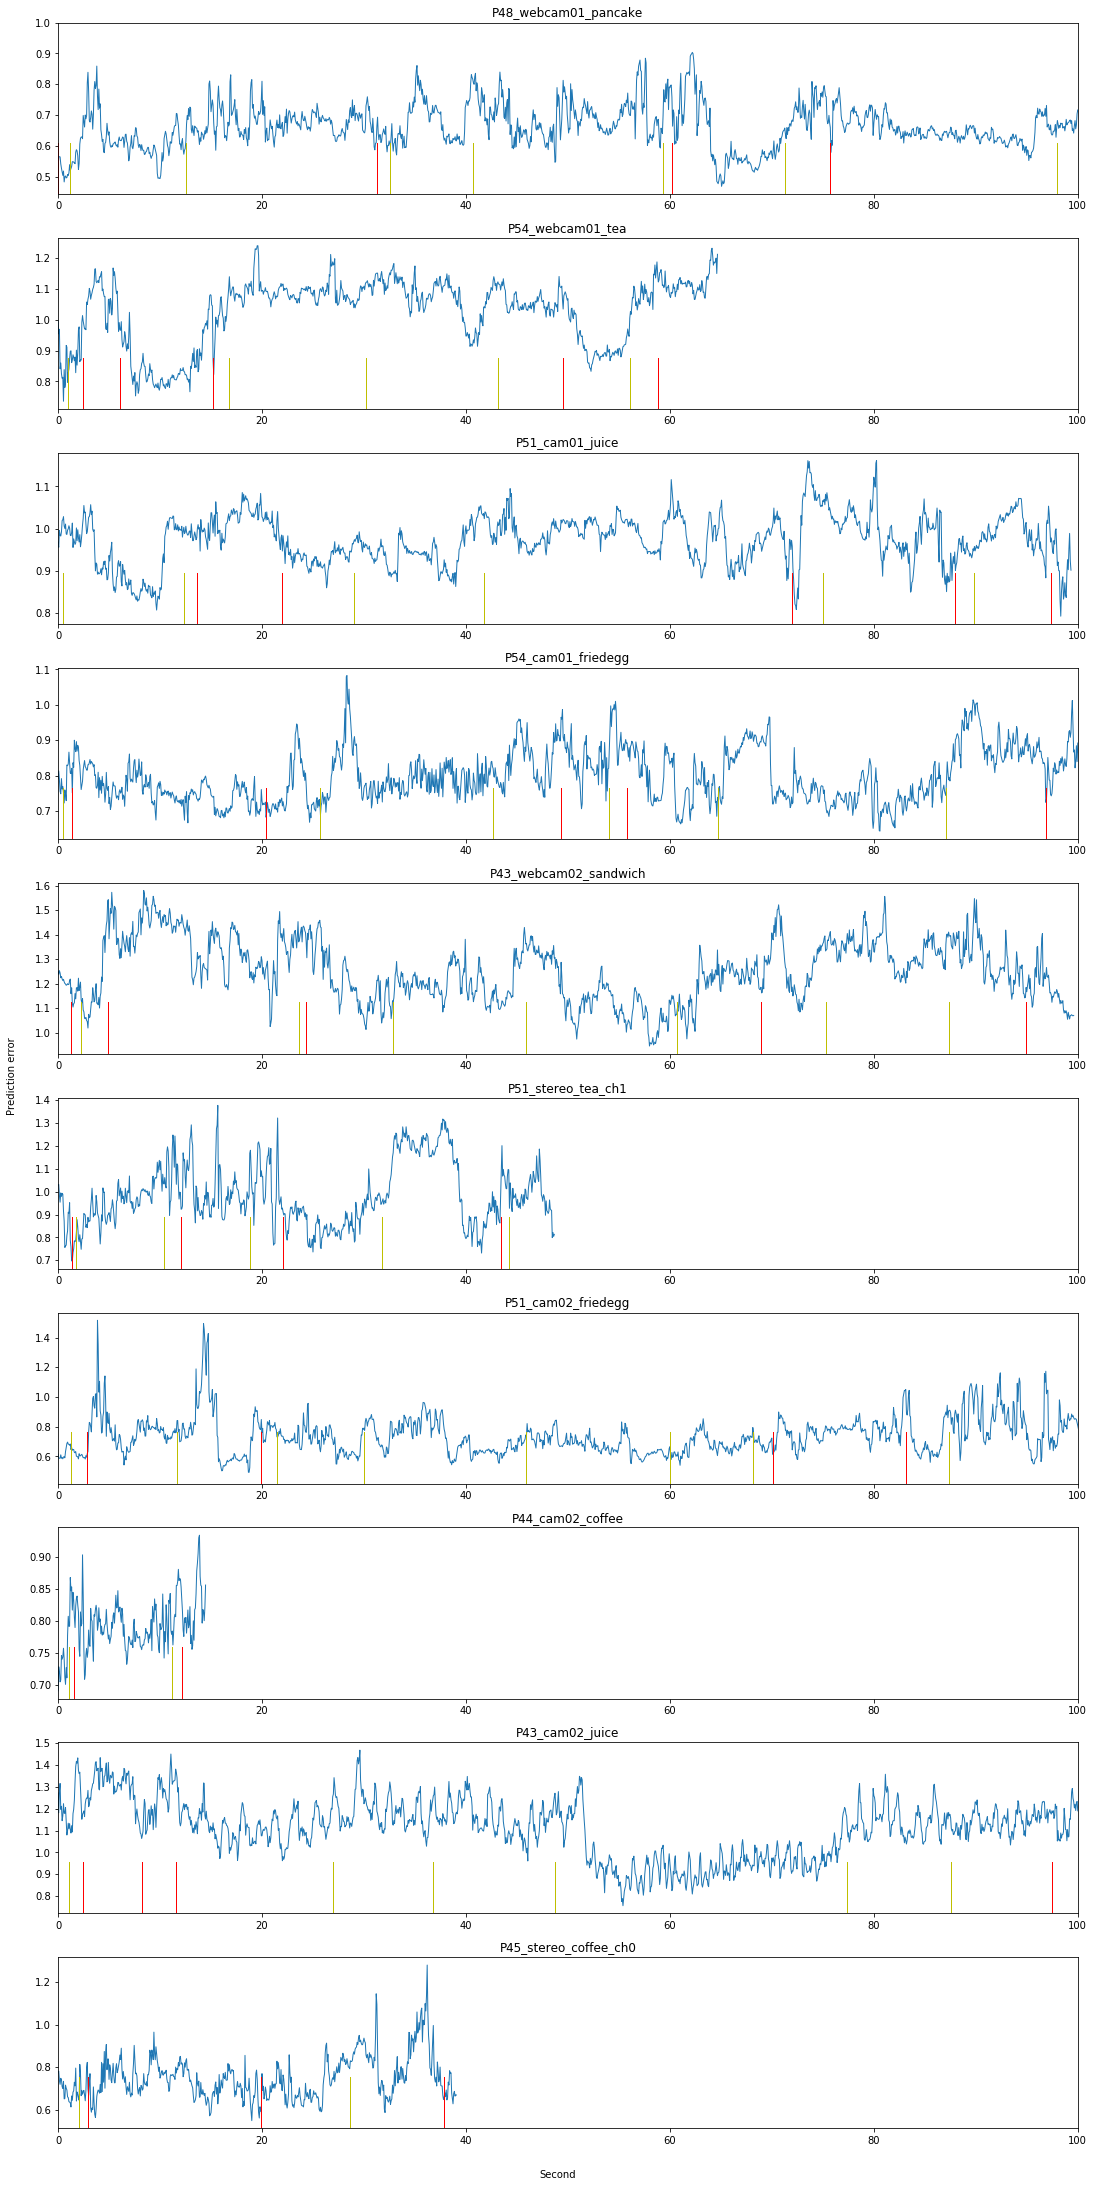

In [15]:
fps = 15
xlim = 100
plot_multi_errors(vd_name_list, fps, loss_list[:10], bdr_list, xlim)

## Evaluation on breakfast dataset

In [16]:
GT_ROOT = "/data4/shetw/breakfast/activity_groundtruth"
def evaluate_mof(vd_name_list, loss_list, bdr_list, gt_root=GT_ROOT):
    avgIoD = []
    for i, vd_name in enumerate(vd_name_list):
        actBoundary = []
        predBoundary = bdr_list[i]
        gtFrames = []
        predFrames = []

        name_splits = vd_name.split('_')
        if name_splits[-1] == 'ch0' or name_splits[-1] == 'ch1':
            gt_name = name_splits[0] + '_' + name_splits[-2] + '.txt'
        else:
            gt_name = name_splits[0] + '_' + name_splits[-1] + '.txt'
        gt_path = os.path.join(gt_root, gt_name)
        # Groundtruth frame labels
        classNo = 0
        with open(gt_path, 'rb') as gt_file:
            for line in gt_file:
                data, className = line[:-3].split(' ')
                fromFrame, toFrame = [int(x) for x in data.split('-')]
                actBoundary.append(toFrame)
                for f in range(fromFrame, toFrame+1):
                    gtFrames.append(classNo) 
                classNo += 1
        # Predicted frame labels
        prevFrame = 0
        predClass = 0
        for nextFrame in predBoundary:
            for i in range(prevFrame, nextFrame):
                predFrames.append(predClass)
            prevFrame = nextFrame
            predClass += 1
        # Equal length
        if len(predFrames) < len(gtFrames):
            x = gtFrames[:len(predFrames)]
            y = predFrames
        else:
            x = gtFrames
            y = predFrames[:len(gtFrames)]
        # Evaluation (recall)
        d = {x:0 for x in range(classNo)}
        for i in range(len(y)):
            if y[i] == x[i]:
                d[y[i]] += 1 # TP predictions
        p = []
        for c, val in d.iteritems():
            detNo = sum([1 for i in y if i == c]) # # predictions
            if detNo == 0:
                continue
            p.append(1.0*val/detNo)
        p = np.mean(p)
        avgIoD.append(p)
    return np.mean(avgIoD)

In [17]:
evaluate_mof(vd_name_list, loss_list, bdr_list)

0.37975672038264613

## In one function for Breakfast dataset

In [80]:
def visualize_boundaries_eval_mof(meta_path, conn, dbname, colname, gridfs_name, exp_id, num_plot, fps, xlim, has_gt=True, xlabel='Second'):
    vd_name_list = load_metafile(meta_path)
    loss, index = load_from_mongoDB(conn, dbname, colname, gridfs_name, exp_id)
    loss_list = split_video_losses(loss, index)
    assert len(vd_name_list) == len(loss_list), print("{} {}".format(len(vd_name_list), len(loss)))    
    bdr_list = [get_boundaries(l) for l in loss_list]
    plot_indices = sorted(random.sample(range(len(loss_list)), num_plot))
    plot_vd_name_list = [vd_name_list[i] for i in plot_indices]
    plot_loss_list = [loss_list[i] for i in plot_indices]
    plot_bdr_list = [bdr_list[i] for i in plot_indices]
    plot_multi_errors(plot_vd_name_list, fps, plot_loss_list, plot_bdr_list, xlim, plot_gt=has_gt)
    if has_gt:
        mof = evaluate_mof(vd_name_list, loss_list, bdr_list)
        print("MOF: {}".format(mof))
    else:
        mof = None
    return vd_name_list, loss_list, bdr_list, mof

MOF: 0.400029903541


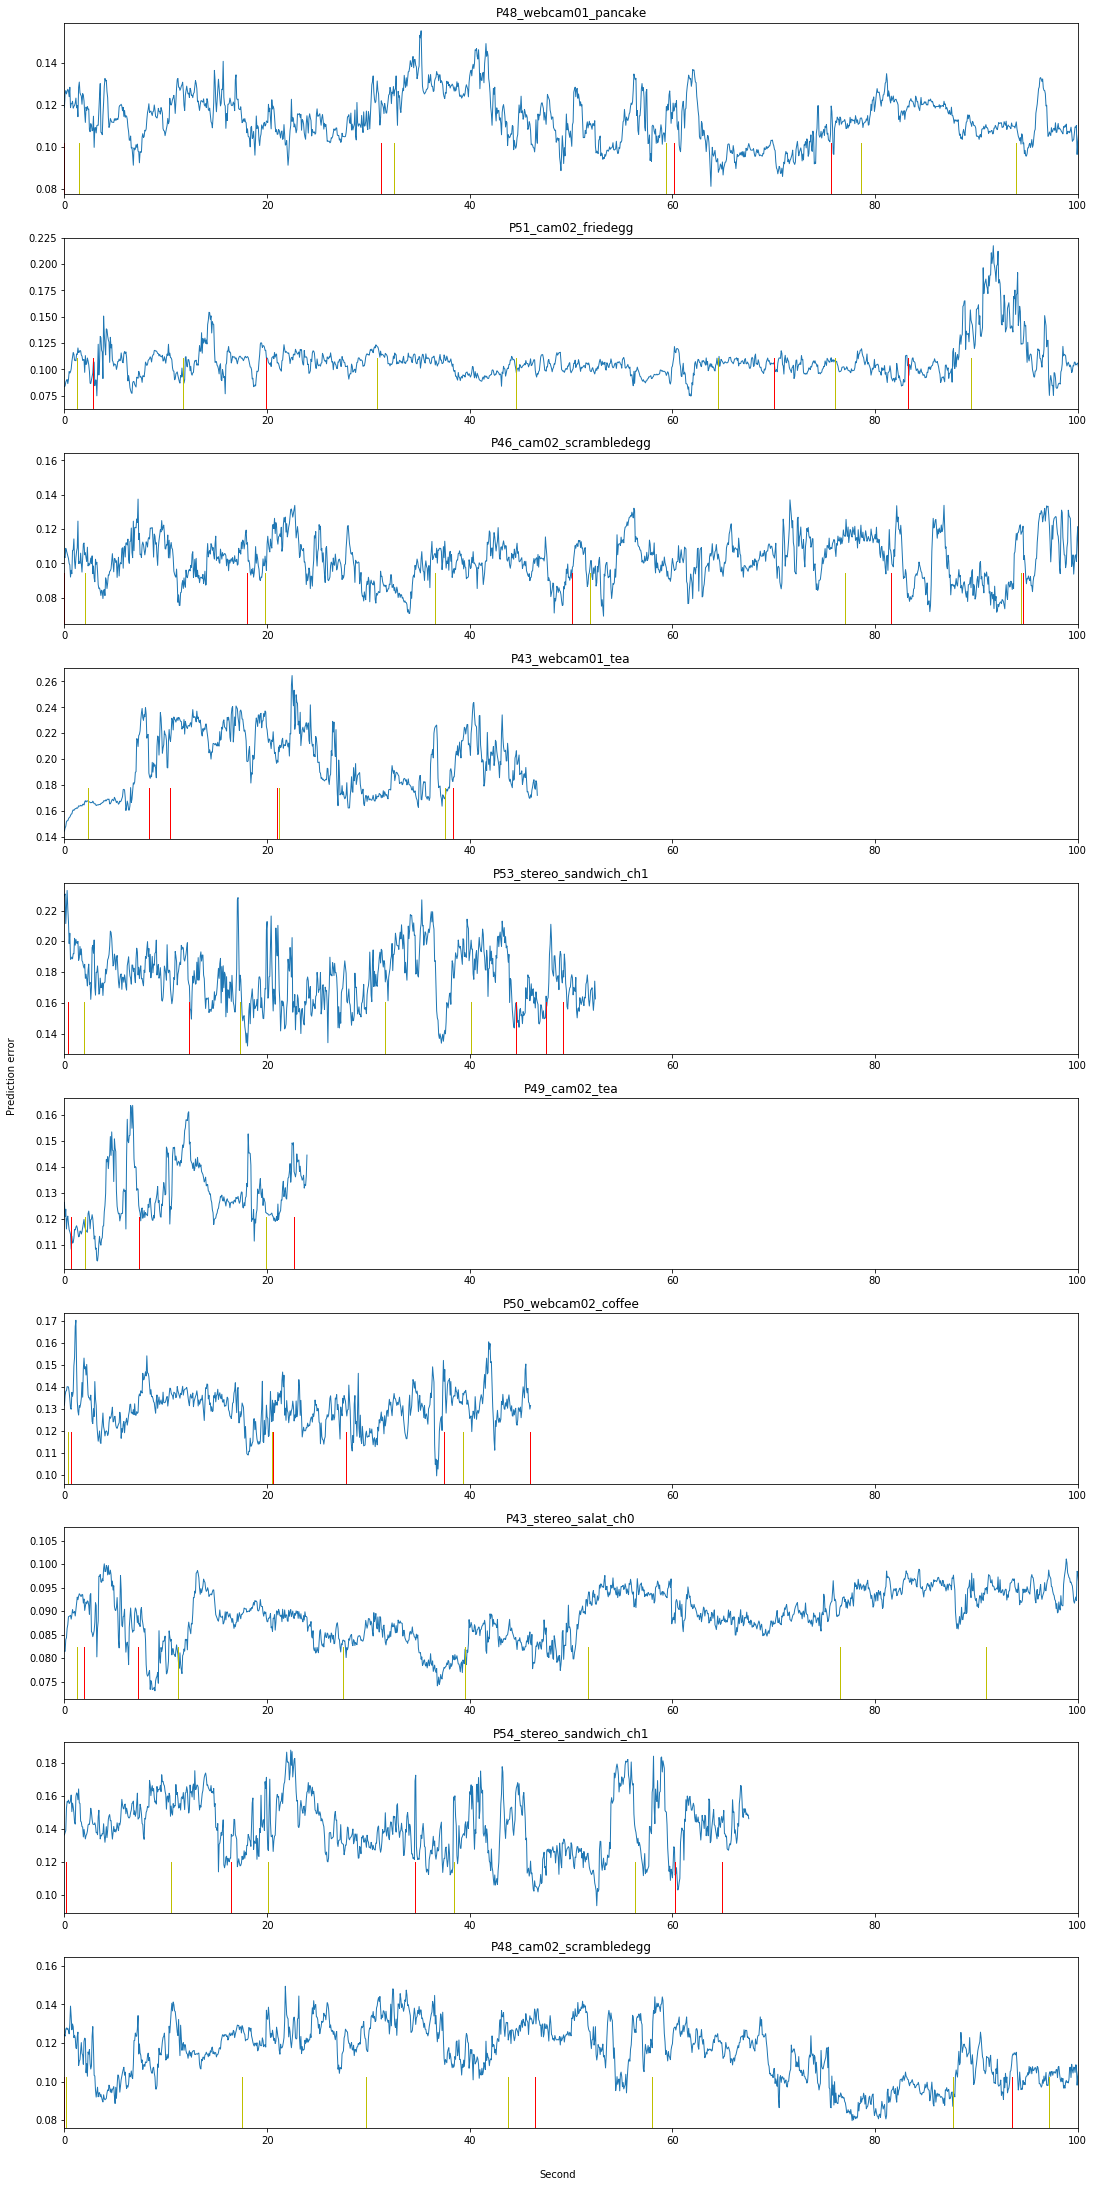

In [105]:
# Database path
conn = pm.MongoClient(port=27007)
dbname = "ppf"
colname = "breakfast_loss.files"
gridfs_name = "breakfast_loss"
exp_id = "ppf_test_sample_lr6"
meta_path = '/data4/shetw/breakfast/metafiles/videos_test_split1_sample.meta'
fps = 15
num_plot = 10
xlim = 100

vd_name_list, bf_loss_list, bdr_list, mof= visualize_boundaries_eval_mof(meta_path, conn, dbname, colname, 
                                                                       gridfs_name, exp_id, num_plot, fps, xlim)

MOF: 0.390706347404


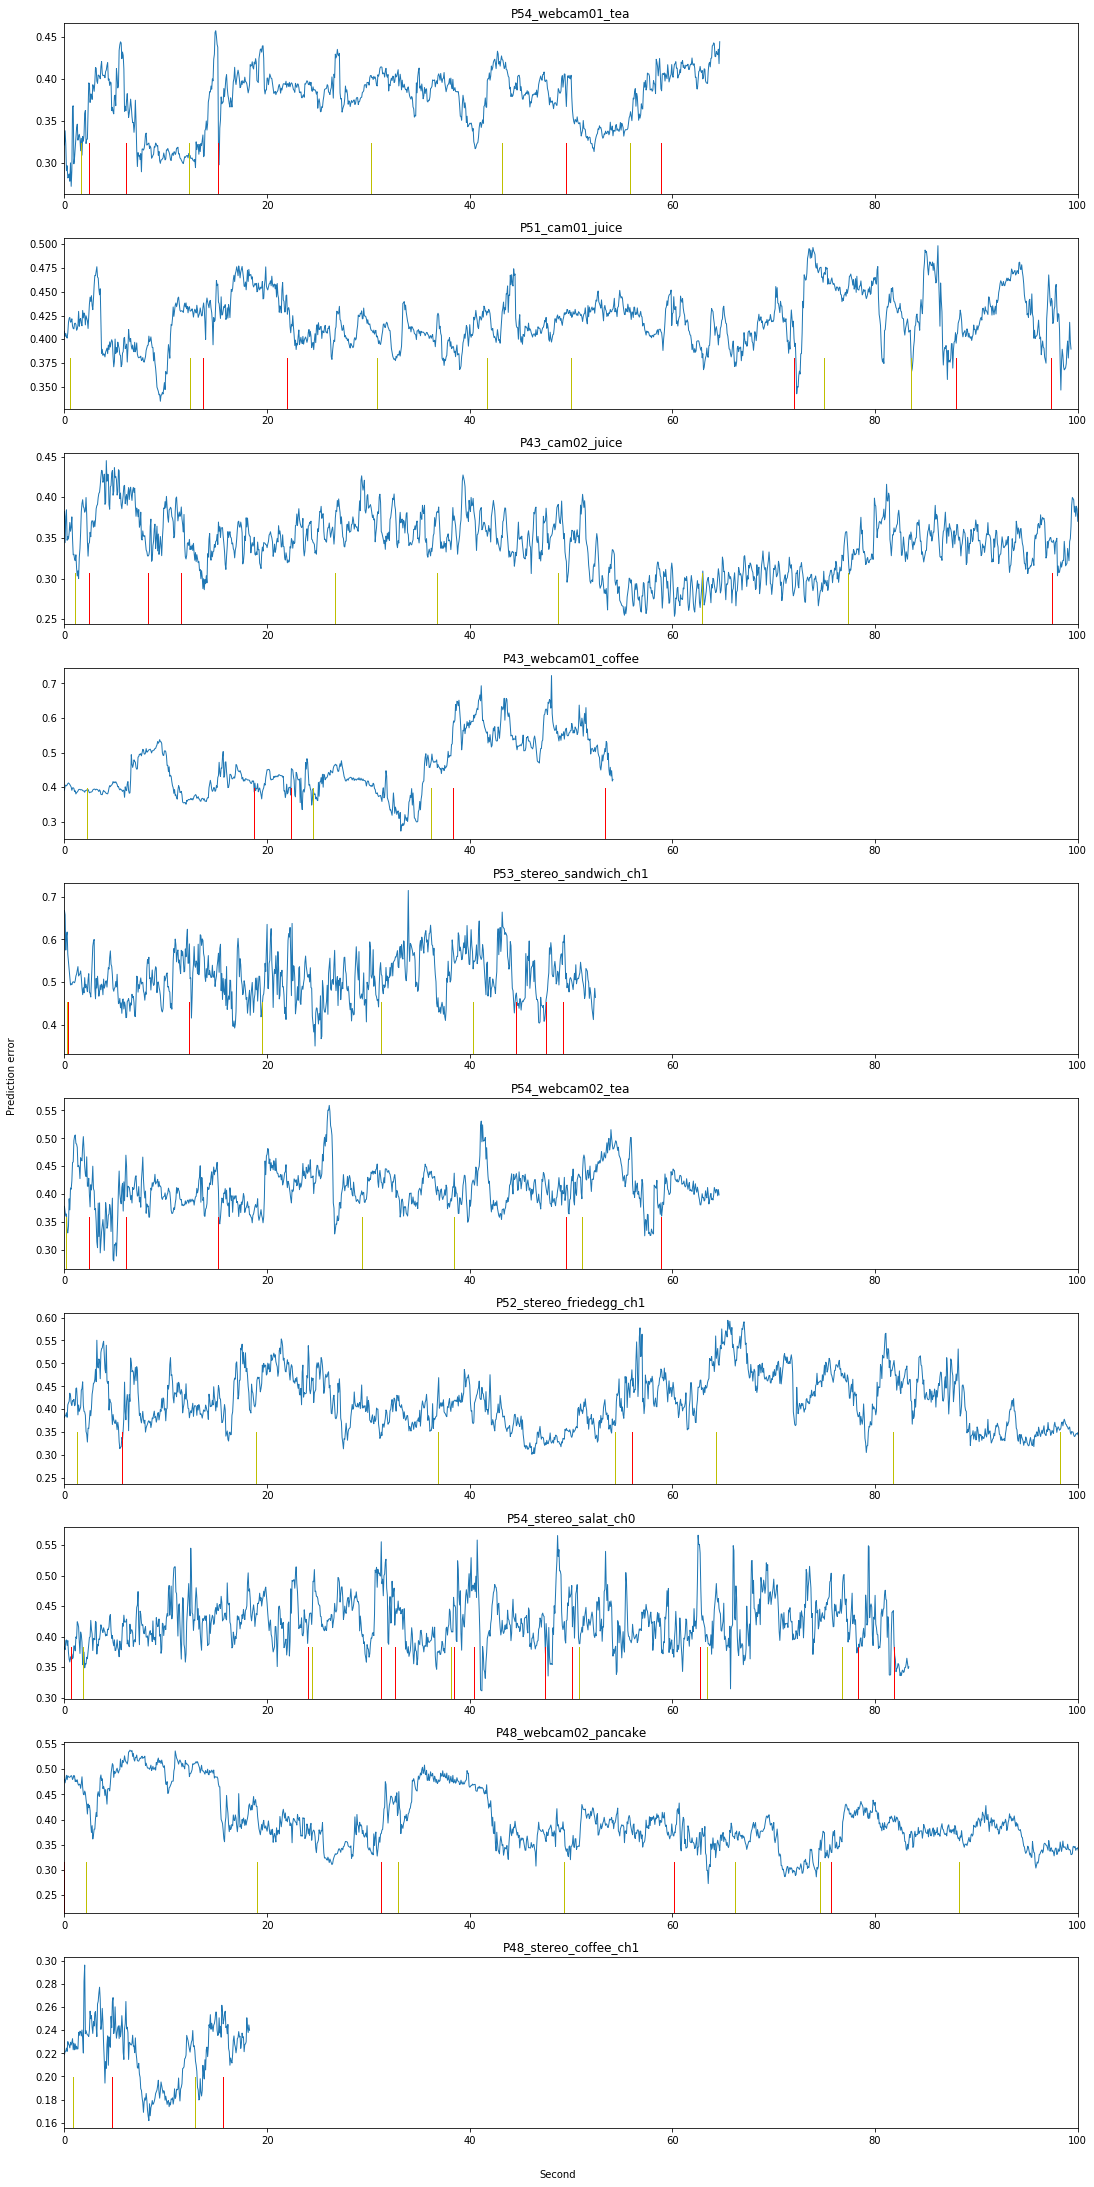

In [82]:
exp_id = "ppf_test_sample_lr7"
vd_name_list, loss_list, bdr_list, mof = visualize_boundaries_eval_mof(meta_path, conn, dbname, colname, 
                                                                       gridfs_name, exp_id, num_plot, fps, xlim)

MOF: 0.393139460877


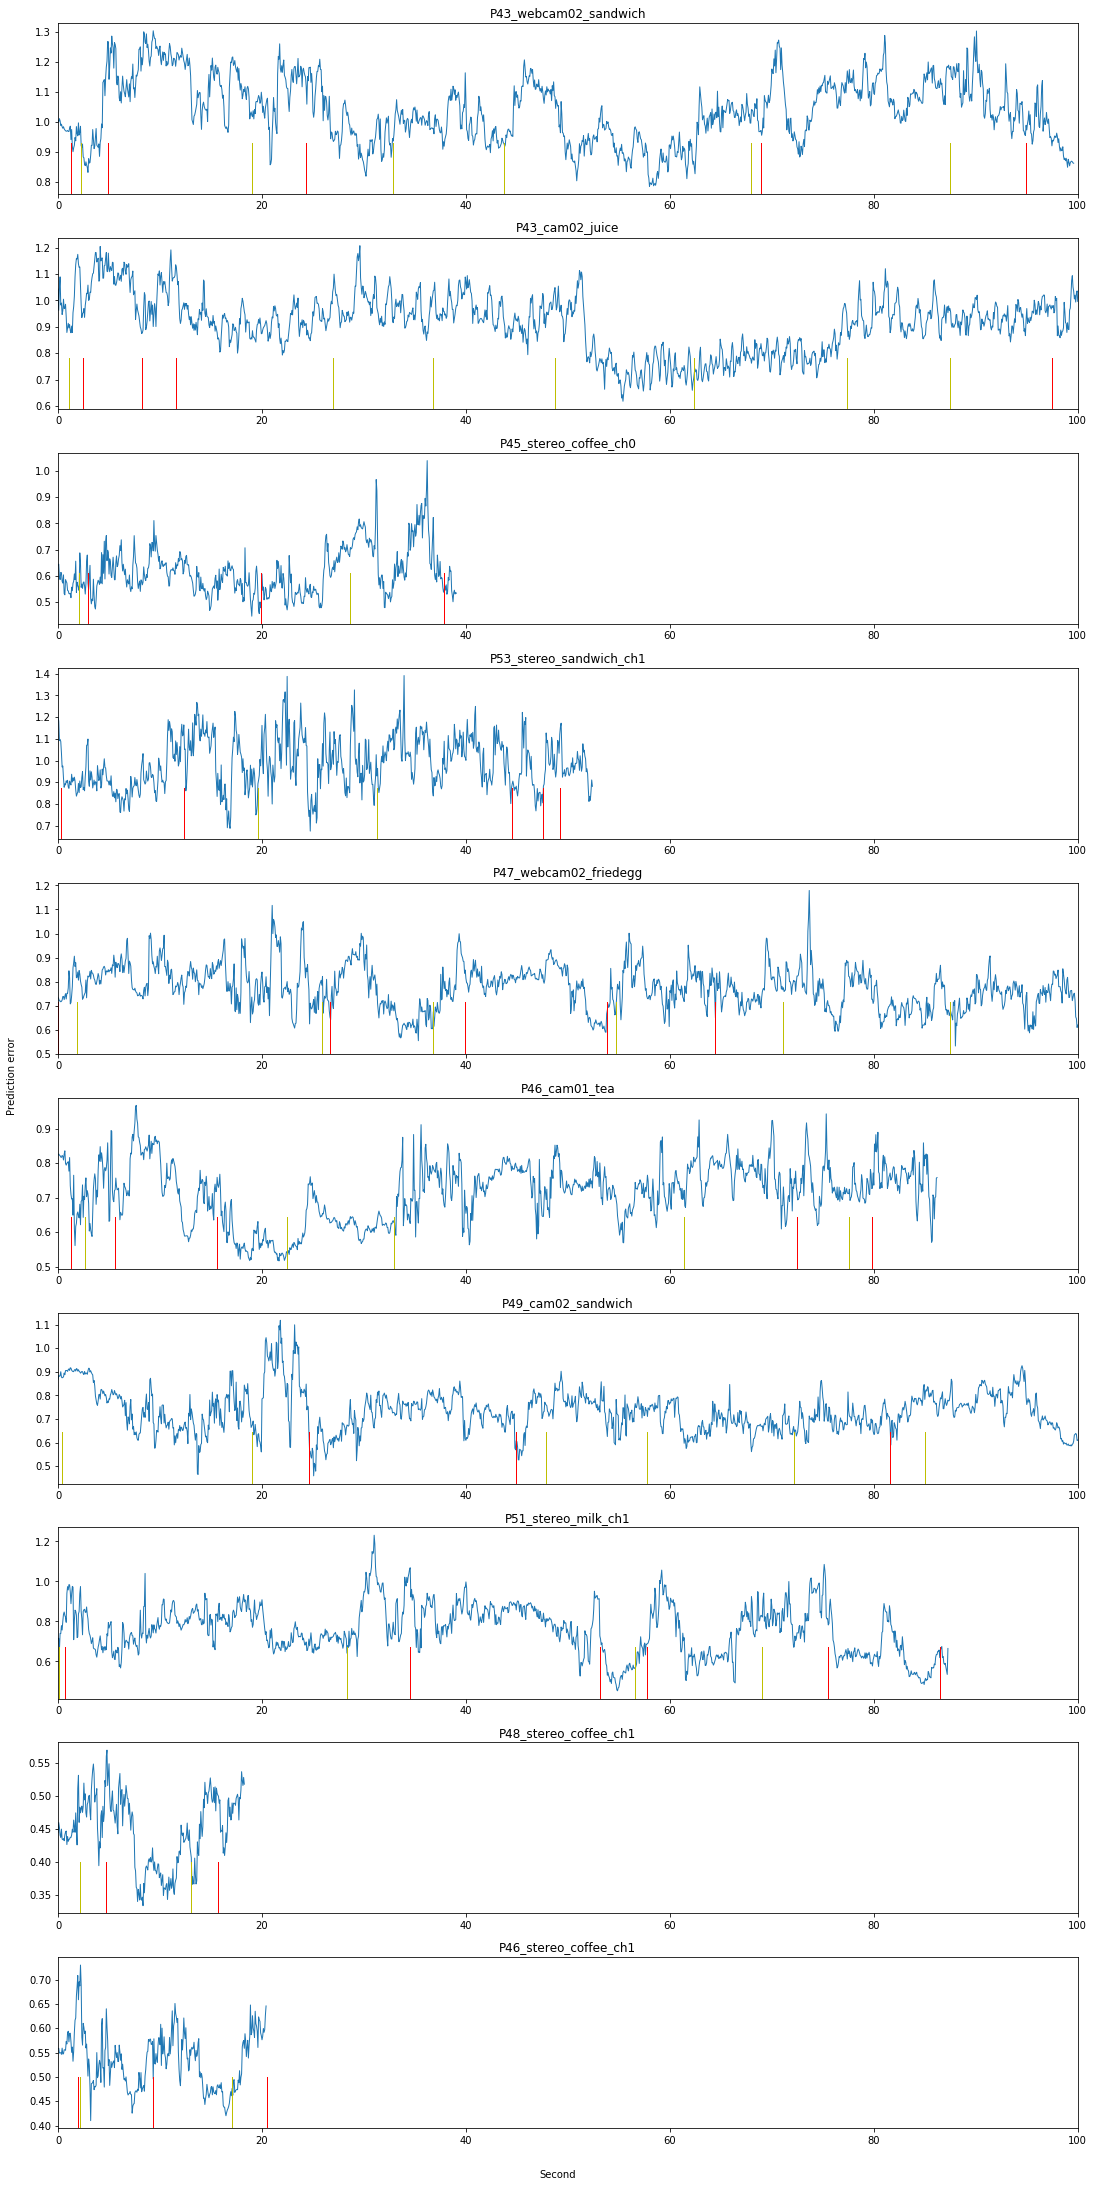

In [128]:
exp_id = "ppf_test_sample_lr59"
num_plot = 1

conn = pm.MongoClient(port=27007)
dbname = "ppf"
colname = "breakfast_loss.files"
gridfs_name = "breakfast_loss"
meta_path = '/data4/shetw/breakfast/metafiles/videos_test_split1_sample.meta'
fps = 15
num_plot = 10
xlim = 100

vd_name_list, loss_list, bdr_list, mof = visualize_boundaries_eval_mof(meta_path, conn, dbname, colname, 
                                                                       gridfs_name, exp_id, num_plot, fps, xlim)

## In one function for infant dataset

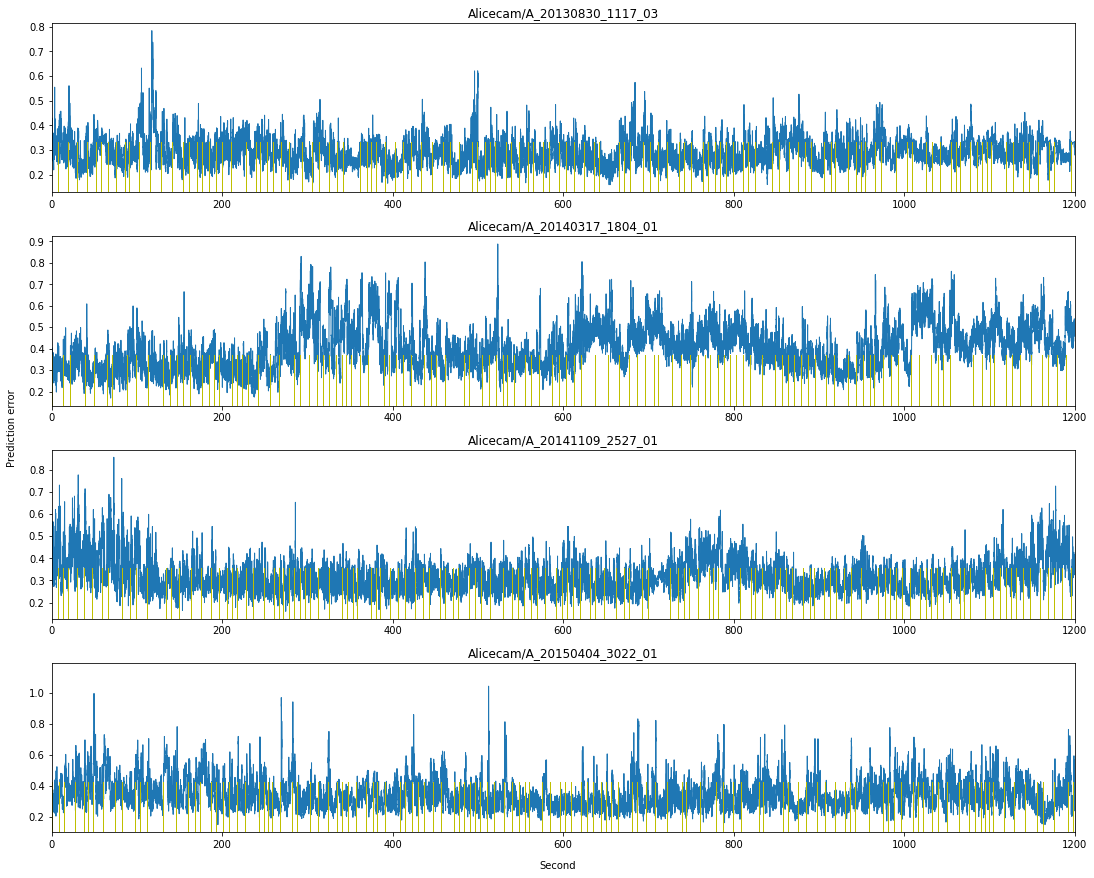

In [87]:
# Database path
conn = pm.MongoClient(port=27007)
dbname = "ppf"
colname = "infant_loss.files"
gridfs_name = "infant_loss"
exp_id = "ppf_test_sample_lr7"
meta_path = '/data/shetw/infant_headcam/metafiles/infant_test_ppf_sample.meta'
fps = 25
num_plot = 4
xlim = 1200
has_gt = False

mof, vd_name_list, loss_list, bdr_list = visualize_boundaries_eval_mof(meta_path, conn, dbname, colname, 
                                                                       gridfs_name, exp_id, num_plot, fps, xlim, has_gt=False)

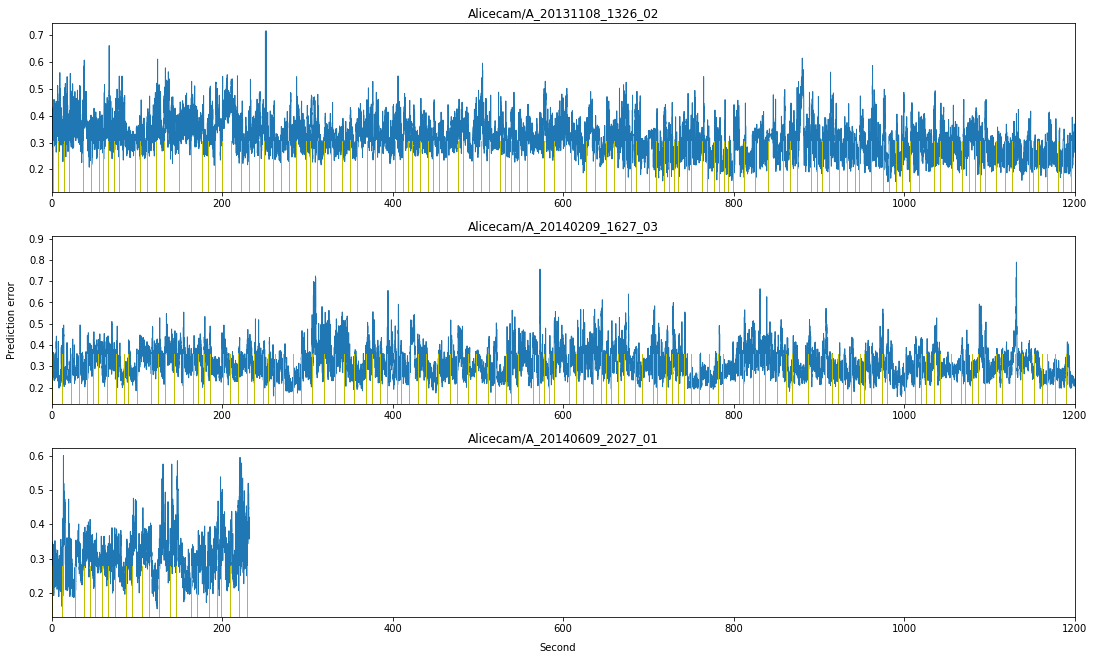

In [88]:
# Database path
exp_id = "ppf_test_sample_lr7_a2"
meta_path = '/data/shetw/infant_headcam/metafiles/infant_test_ppf_sample_a2.meta'

mof, vd_name_list, loss_list, bdr_list = visualize_boundaries_eval_mof(meta_path, conn, dbname, colname, 
                                                                       gridfs_name, exp_id, num_plot, fps, xlim, has_gt=False)

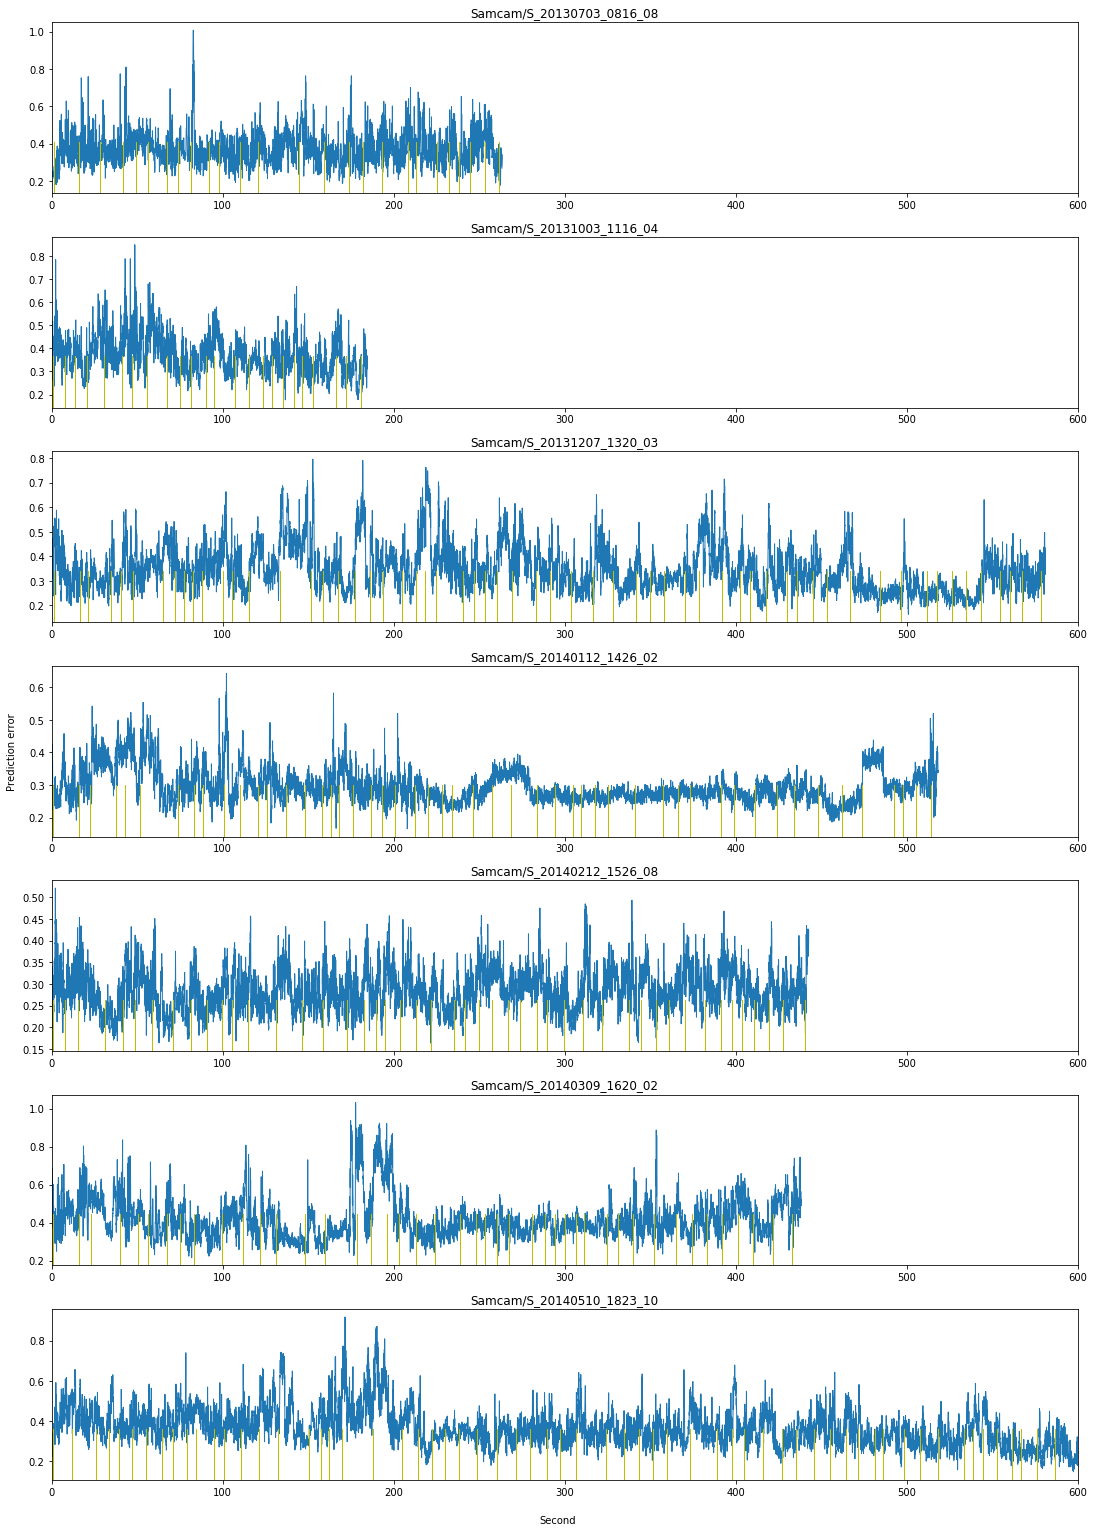

In [90]:
# Database path
exp_id = "ppf_test_sample_lr7_s1"
meta_path = '/data/shetw/infant_headcam/metafiles/infant_test_ppf_sample_s1.meta'
num_plot = 7
xlim = 600

mof, vd_name_list, loss_list, bdr_list = visualize_boundaries_eval_mof(meta_path, conn, dbname, colname, 
                                                                       gridfs_name, exp_id, num_plot, fps, xlim, has_gt=False)

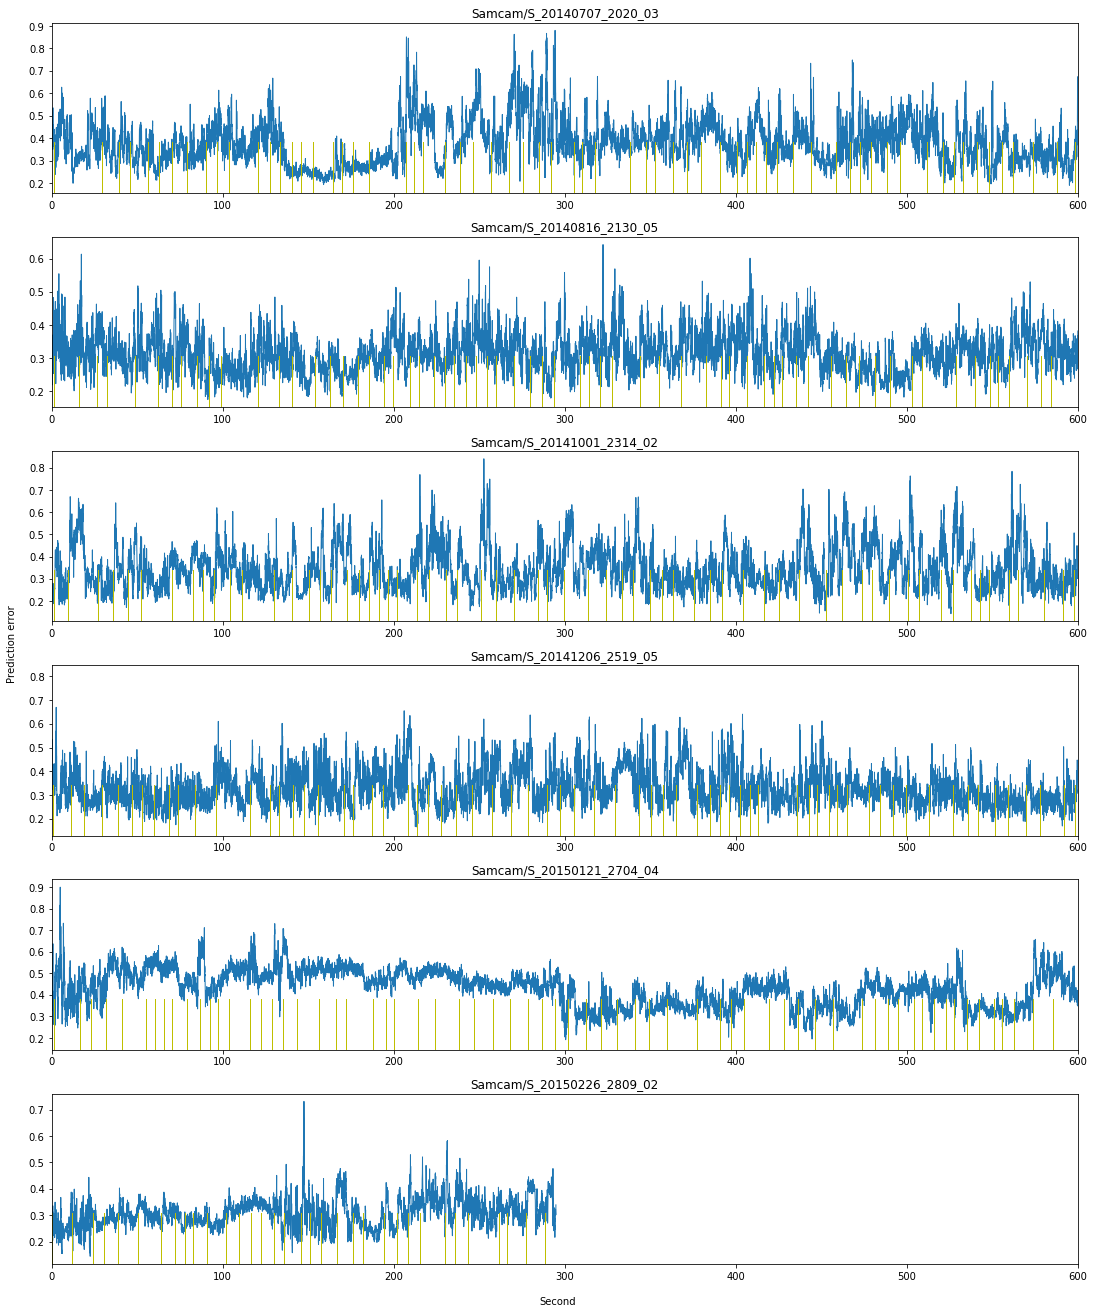

In [91]:
exp_id = "ppf_test_sample_lr7_s2"
meta_path = '/data/shetw/infant_headcam/metafiles/infant_test_ppf_sample_s2.meta'
num_plot = 6
xlim = 600

mof, vd_name_list, loss_list, bdr_list = visualize_boundaries_eval_mof(meta_path, conn, dbname, colname, 
                                                                       gridfs_name, exp_id, num_plot, fps, xlim, has_gt=False)